In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

import nltk

In [2]:
train = pd.read_csv(r'C:\Users\Monish Kumar\Python projects\OCR + NLP\imdb_small.csv')
test = pd.read_csv(r'C:\Users\Monish Kumar\Python projects\OCR + NLP\test.csv')

map_dict = {'negative':0,'positive':1}
train =train.replace({'sentiment':map_dict})  

# 1. Basic EDA

## Number of Words


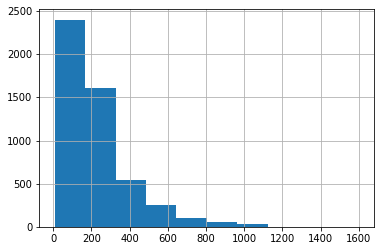

In [3]:
train['word_count'] = train['review'].apply(lambda x: len(x.split(" ")))
train['word_count'].hist()

##### Seems like afew reviews are over 1500 words!

## Number of characters

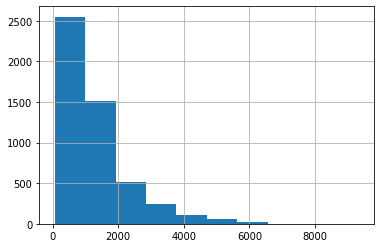

In [4]:
train['character_count']=train['review'].apply(lambda x: len(x))
train['character_count'].hist()

## Average word length

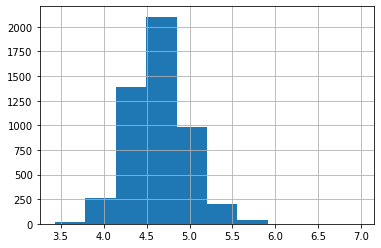

In [5]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

train['avg_word_len'] = train['review'].apply(lambda x: avg_word(x))
train['avg_word_len'].hist()

## Counting number of stopwords

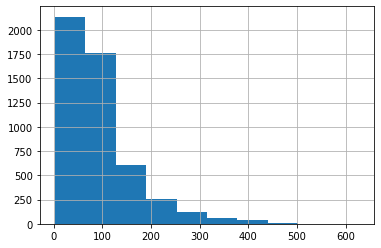

In [6]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

def countstopwords(sentence):
    count = 0
    for i in (sentence.split()):
        if i in stop_words:
            count +=1 
    return count

train['stopwords'] = train['review'].apply(lambda x: countstopwords(x))
train['stopwords'].hist()

## Number of numerics

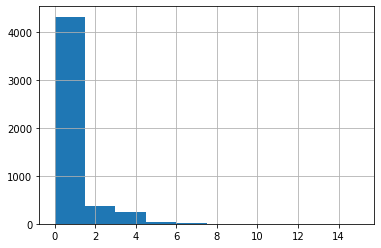

In [7]:
train['numerics'] = train['review'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
train['numerics'].hist()

## Number of Uppercase words

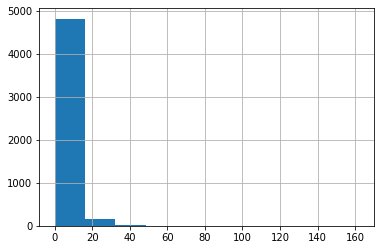

In [8]:
train['upper'] = train['review'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
train['upper'].hist()

##### Lets check whether these upper-case words affect the sentiment of the review

In [9]:
a = train['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
a = a.apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
a.apply(lambda x: len([x for x in x.split() if x.isupper()])).value_counts()

0    5000
Name: review, dtype: int64

##### Seems like all the upper-case (ALL CAPS) words were words like 'I' ,'A', etc... Therefore, they wont affect the sentiment

### - Also check if punctuations(like '!','quotes/duoble-quotes',etc...) affect the sentiment - Do the similar thing what you did for common word removel

# 2. Cleaning our Data (Noise Removal)

## 2.1. Removing line breaks

In [10]:
train['review'] = train['review'].apply(lambda x: x.replace('<br />',' '))
test['review'] = test['review'].apply(lambda x: x.replace('<br />',' '))

##  2.2. Removing Punctuations

In [11]:
train['review'] = train['review'].str.replace('[^\w\s]',' ')
test['review'] = test['review'].str.replace('[^\w\s]',' ')
train['review'].head()

0    I have to differ from the other comments poste...
1    I saw this movie with low expectations and was...
2    Taran Adarsh a reputed critic praised such a d...
3    When I first heard that the subject matter for...
4    With the release of Peter Jackson s famed  Lor...
Name: review, dtype: object

##  2.3. Number to words

In [12]:
# After converting we get '-' sometimes - so we need to do punctuation removal again...
import num2words
num2words.num2words(834)

'eight hundred and thirty-four'

In [13]:
def convertnum2words (sentence):
    new_sentence = sentence
    for i in sentence.split():
        if i.isdigit():
            sentence = sentence.replace(i,num2words.num2words(int(i)))
    return sentence

train['review'] = train['review'].apply(lambda x: convertnum2words(x))
test['review'] = test['review'].apply(lambda x: convertnum2words(x))

train['review'] = train['review'].str.replace('-',' ')
test['review'] = test['review'].str.replace('-',' ')

train['review'].head()

0    I have to differ from the other comments poste...
1    I saw this movie with low expectations and was...
2    Taran Adarsh a reputed critic praised such a d...
3    When I first heard that the subject matter for...
4    With the release of Peter Jackson s famed  Lor...
Name: review, dtype: object

## 2.4. Lower Case
- If not done the model will treat the words 'Movie' and 'movie' differently even though they mean the same.

In [14]:
train['review'] = train['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
test['review'] = test['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
train['review'].head()

0    i have to differ from the other comments poste...
1    i saw this movie with low expectations and was...
2    taran adarsh a reputed critic praised such a d...
3    when i first heard that the subject matter for...
4    with the release of peter jackson s famed lord...
Name: review, dtype: object

## 2.5. Removing Stopwords

In [15]:
train['review'] = train['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
test['review'] = test['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
train['review'].head()

0    differ comments posted amid sporadic funny mom...
1    saw movie low expectations disappointed bad ac...
2    taran adarsh reputed critic praised dubba movi...
3    first heard subject matter checking self orche...
4    release peter jackson famed lord rings trilogy...
Name: review, dtype: object

## 2.6. Lemmatization
 - We wont use stemming coz it is just cutting of words to it's root where in most cases we will end up with meaningless words.
 - While in Lemmatization we wil for word (root) with meaning (present in dictionary).

In [16]:
from textblob import Word

train['review'] = train['review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
test['review'] = test['review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
train['review'].head()

0    differ comment posted amid sporadic funny mome...
1    saw movie low expectation disappointed bad act...
2    taran adarsh reputed critic praised dubba movi...
3    first heard subject matter checking self orche...
4    release peter jackson famed lord ring trilogy ...
Name: review, dtype: object

## Visualising common words (excluding stop words) for both sentiments seperately
 - Words like 'movie' and 'film' occur commonly in both the classes (sentiments) so classifying a review based on these kind of words is impossible.
 - Note that the word 'good' occurs in both classes pretty commonly while the word 'bad' occurs only in the negative class!
 - Therefore we should delete the word 'good' and keep the word 'bad'

In [17]:
commonword_neg = pd.Series(' '.join(train[train.sentiment == 0]['review']).split()).value_counts()[:40]
commonword_pos = pd.Series(' '.join(train[train.sentiment == 1]['review']).split()).value_counts()[:40]

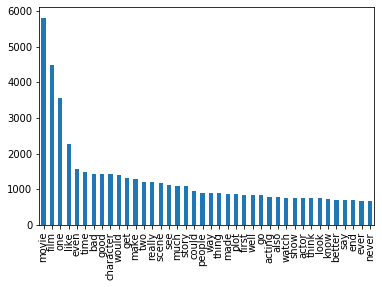

In [18]:
commonword_neg.plot(kind='bar')

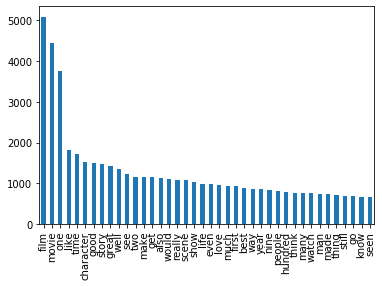

In [19]:
commonword_pos.plot(kind='bar')

In [20]:
common = []
for word in (commonword_pos.index):
    if word in (commonword_neg.index):
        common.append(word)

## 2.7. Common word removal

In [21]:
train['review'] = train['review'].apply(lambda x: " ".join(x for x in x.split() if x not in common))
test['review'] = test['review'].apply(lambda x: " ".join(x for x in x.split() if x not in common))
train['review'].head()

0    differ comment posted amid sporadic funny mome...
1    saw low expectation disappointed bad actually ...
2    taran adarsh reputed critic praised dubba weir...
3    heard subject matter checking self orchestrate...
4    release peter jackson famed lord ring trilogy ...
Name: review, dtype: object

## 2.8. Rare words removal
 - Removing words which occured only once in the whole corpus doesnt contribute much to the prediction.

In [22]:
rarewords = pd.Series(' '.join(train['review']).split()).value_counts()
rarewords = rarewords[rarewords==1]

rarewords = list(rarewords.index)
train['review'] = train['review'].apply(lambda x: " ".join(x for x in x.split() if x not in rarewords))
test['review'] = test['review'].apply(lambda x: " ".join(x for x in x.split() if x not in rarewords))
train['review'].head()

0    differ comment posted amid sporadic funny mome...
1    saw low expectation disappointed bad actually ...
2    reputed critic praised weird wherein lover sel...
3    heard subject matter checking self orchestrate...
4    release peter jackson famed lord ring trilogy ...
Name: review, dtype: object

## Spell Check and Slang correction - Must be done before common word removal
 - When compared with TextBlob GingerIt seems to perform well
 - But it takes an awfull lot of time to proccess even few sentences so we are not going to use it.
 - Still, if you are planning to use this step must be done before Lowercasing (Gingerit library seems to convert 1st letter of each sentence to a capital letter) and Stopword removal step.

In [23]:
from textblob import TextBlob
TextBlob("hey theere. come wid me. u r awsm.").correct()

TextBlob("hey there. come wid me. u r was.")

In [24]:
from gingerit.gingerit import GingerIt
GingerIt().parse("hey theere. come wid me. u r awsm.")['result']

'Hey there. Come with me. You are awesome.'

In [25]:
train['review'][:4].apply(lambda x: GingerIt().parse(x.lower())['result'])

0    Differ comment posted amid sporadic funny mome...
1    Saw low expectation disappointed bad actually ...
2    Reputed critic praised weird wherein lover sel...
3    Heard subject matter checking self orchestrate...
Name: review, dtype: object

# 3. Feature Extraction

## 3.1. Bag of Words

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1500,
                      lowercase=True,
                      ngram_range=(1,3),
                      analyzer = "word")
train_bow = bow.fit_transform(train['review'])
test_bow = bow.transform(test['review'])

## 3.2. TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1500,
                        lowercase=True,
                        analyzer='word',
                        stop_words= 'english',
                        ngram_range=(1,1))

train_vect = tfidf.fit_transform(train['review'])
test_vect = tfidf.transform(test['review'])

#### -  Another feature extraction method is using Word2Vec

# 4. Model Training
- Since we were asked mainly to concentrate on preprocessing the data I will just use LogisticRegression and Neural Network alone here...

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

x = pd.DataFrame(train_vect.toarray())
y = train.sentiment

x_tr, x_ts, y_tr, y_ts = train_test_split(x,y,test_size=0.3)



## Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression

logreg_score = cross_val_score(LogisticRegression(),x,y,cv=5,scoring='f1')
print('F1 score with 95% confidence:',round(logreg_score.mean(),3),'+/-',round((logreg_score.std() * 3),3))

F1 score with 95% confidence: 0.85 +/- 0.048


## Neural Network

In [30]:
import keras
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(50, input_shape=(1500,), activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_tr, y_tr,validation_data = (x_ts,y_ts), epochs=10, batch_size=200)

Using TensorFlow backend.


Train on 3500 samples, validate on 1500 samples
Epoch 1/10
3500/3500 [==============================] - 1s 150us/step - loss: 0.6869 - accuracy: 0.6100 - val_loss: 0.6741 - val_accuracy: 0.7520
Epoch 2/10
3500/3500 [==============================] - 0s 65us/step - loss: 0.6382 - accuracy: 0.8403 - val_loss: 0.6005 - val_accuracy: 0.8187
Epoch 3/10
3500/3500 [==============================] - 0s 76us/step - loss: 0.5204 - accuracy: 0.8614 - val_loss: 0.4745 - val_accuracy: 0.8380
Epoch 4/10
3500/3500 [==============================] - 0s 67us/step - loss: 0.3781 - accuracy: 0.8769 - val_loss: 0.3829 - val_accuracy: 0.8440
Epoch 5/10
3500/3500 [==============================] - 0s 58us/step - loss: 0.2810 - accuracy: 0.8989 - val_loss: 0.3497 - val_accuracy: 0.8467
Epoch 6/10
3500/3500 [==============================] - 0s 40us/step - loss: 0.2260 - accuracy: 0.9189 - val_loss: 0.3478 - val_accuracy: 0.8473
Epoch 7/10
3500/3500 [==============================] - 0s 43us/step - loss: 0.19

In [31]:
from sklearn.metrics import confusion_matrix,f1_score
y_pred = model.predict(x_ts)
y_pred = (y_pred>0.5)
confusion_matrix(y_ts,y_pred)

array([[634, 130],
       [106, 630]], dtype=int64)

In [32]:
f1_score(y_ts,y_pred)

0.8422459893048129

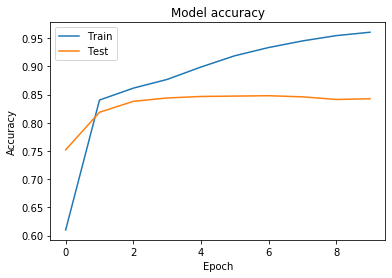

In [33]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

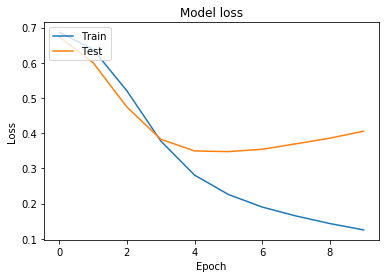

In [34]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

# Result - Test Prediction

In [41]:
clf = LogisticRegression()
clf.fit(pd.DataFrame(train_vect.toarray()),y)
test_pred = pd.DataFrame(clf.predict(test_vect),columns=['sentiment'])

In [42]:
final_output = pd.concat([test,test_pred],axis=1)
final_output

,review,sentiment
0,laughed rotten unbelievable woman leaf husband...,0
1,watched fingersmith stunned eight ten average ...,0
2,liked towards firat half progressed became worse,0
3,bad boy life trailer,1
4,nothing else tv bored phat beach however rent ...,0
5,normally series predictable tend become boring...,0
6,absolutely sense every week lady estate garden...,1
7,watched hot guy sucked worst okay give prop fr...,0
8,consider bit connoisseur boxing prevents calli...,1
9,watched countless never failed charmed homely ...,1


In [47]:
clf.predict_proba(test_vect)

array([[0.51962465, 0.48037535],
       [0.84305739, 0.15694261],
       [0.70173179, 0.29826821],
       [0.48857824, 0.51142176],
       [0.55584894, 0.44415106],
       [0.62874811, 0.37125189],
       [0.38066477, 0.61933523],
       [0.97162679, 0.02837321],
       [0.09524972, 0.90475028],
       [0.13234856, 0.86765144],
       [0.79234414, 0.20765586],
       [0.41584992, 0.58415008],
       [0.49781143, 0.50218857]])